<a href="https://colab.research.google.com/github/l-guilherme/IA/blob/main/aula6b_%C3%81rvores_de_decis%C3%A3o_atributos_cont%C3%ADnuos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Árvore de decisão para atributos contínuos

In [90]:
from sklearn.datasets import load_wine
dataset = load_wine()
X, y = dataset.data, dataset.target
X.shape

(178, 13)

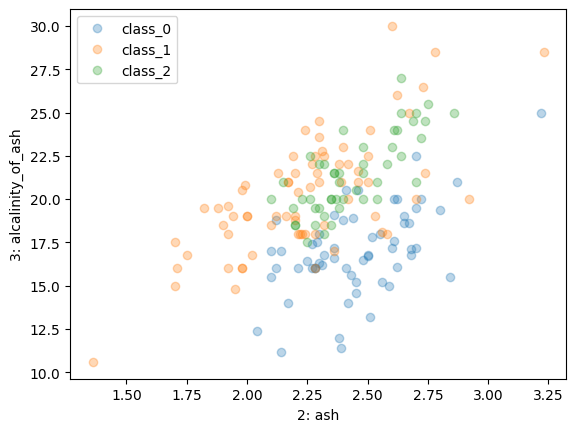

In [60]:
import matplotlib.pyplot as plt
i, j = 2, 3
plt.xlabel(f"{i}: {dataset.feature_names[i]}")
plt.ylabel(f"{j}: {dataset.feature_names[j]}")

for k in set(y):
  plt.plot(X[:,i][y==k], X[:,j][y==k], 'o', alpha=0.3,
           label=f"{dataset.target_names[k]}")
plt.legend()
plt.show()

In [61]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
import numpy as np
from sklearn.model_selection import cross_validate

def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

class ZeroR(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    y[:] = self.resposta
    return y

scores = cross_validate(ZeroR(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.        , 0.36111111, 0.        , 0.        , 0.        ]),
 0.07222222222222222)

In [62]:
modelo = ZeroR()
modelo.fit(X, y)
modelo.resposta

1

In [63]:
modelo = ZeroR()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.398876404494382

In [64]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica = 2
    self.valor = np.mean(X[:,self.caracteristica])
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

0.702247191011236

In [65]:
scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.05555556, 0.30555556, 0.25      , 0.25714286, 0.14285714]),
 0.20222222222222222)

In [66]:
def impureza(y): #Gini
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i, k in enumerate(labels):
    probabilidades[i] = sum(y==k)/len(y)
  result = 1 - sum(probabilidades ** 2)
  return result

impureza(y[:])

0.6583133442747129

In [67]:
def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezamaiores = impureza(y[maiores])
  proporcaomaiores = sum(maiores)/len(y)
  impurezamenores = impureza(y[~maiores])
  proporcaomenores = sum(~maiores)/len(y)
  impurezaTotal = proporcaomaiores*impurezamaiores + proporcaomenores*impurezamenores
  return impurezaTotal, impurezamenores, impurezamaiores

impurezaValor(X[:,2], y, 2.5)

(0.6434985114760395, 0.6419753086419754, 0.647189349112426)

In [68]:
def melhorValor(x, y):
  result = None
  menorImpureza = float('inf')
  xmax = np.max(x)
  xmin = np.min(x)
  while True:
    valor = (xmin+xmax)/2
    impTotal, impMenores, impMaiores = impurezaValor(x, y, valor)
    if impTotal < menorImpureza:
      menorImpureza = impTotal
      result = valor
      if impMaiores == 0 or impMenores == 0:
        break
      if impMaiores < impMenores:
        xmin = valor
      else:
        xmax = valor
    else:
      break
  return result, menorImpureza

melhorValor(X[:,2], y)

(2.295, 0.6139307817100282)

In [73]:
def melhorValor_nova(x, y):
    result = None
    menorImpureza = float('inf')

    # Ordenar os valores de x e seus respectivos y
    indices_ordenados = np.argsort(x)
    x_ordenado = x[indices_ordenados]
    y_ordenado = y[indices_ordenados]

    # Calcular os valores médios entre instâncias consecutivas
    valores_medios = (x_ordenado[:-1] + x_ordenado[1:]) / 2

    # Testar cada valor médio como possível ponto de separação
    for valor in valores_medios:
        impTotal, impMenores, impMaiores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor

    # If no suitable split point is found, return the mean of x
    if result is None:  # Add this condition
        result = np.mean(x)  # Return the mean if result is None

    return result, menorImpureza

In [74]:
heuristica_nova = False

def melhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    if heuristica_nova:
      valor, imp = melhorValor_nova(X[:,caracteristica], y)
    else:
      valor, imp = melhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)

  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return impurezas[caracteristica], caracteristica, valores[caracteristica]

melhorCaracteristica(X, y)

(0.43761750381193476, 12, 979.0)

In [102]:
import time

class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.impureza, self.caracteristica, self.valor = melhorCaracteristica(X, y)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X, y=None):
    y = np.empty((X.shape[0]))
    if hasattr(self, 'resposta'):
      y[:] = self.resposta
    else:
      if self.caracteristica < X.shape[1]:
        maiores = X[:,self.caracteristica] > self.valor
        y[maiores] = self.maiores.predict(X[maiores,:])
        y[~maiores] = self.menores.predict(X[~maiores,:])
      else:
        y[:] = maisFrequente(y)
    return y

heuristica_nova = False

modelo = Arvore()
inicio = time.time()
modelo.fit(X, y)
print(f'Tempo de treinamento da Árvore original: {time.time() - inicio:.4f} segundos')
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

heuristica_nova = True

modelo = Arvore()
inicio = time.time()
modelo.fit(X, y)
print(f'Tempo de treinamento da Árvore com a Nova Heurística: {time.time() - inicio:.4f} segundos')
ypred = modelo.predict(X)
sum(y==ypred)/len(y)

Tempo de treinamento da Árvore original: 0.2596 segundos
Tempo de treinamento da Árvore com a Nova Heurística: 5.2774 segundos


1.0

In [103]:
heuristica_nova = False
scores = cross_validate(Arvore(), X, y)
print('Scores com a heurística original')
print(scores['test_score'], np.mean(scores['test_score']))

heuristica_nova = True
scores = cross_validate(Arvore(), X, y)
print('Scores com a nova heurística')
print(scores['test_score'], np.mean(scores['test_score']))

Scores com a heurística original
[0.91666667 0.63888889 0.86111111 0.85714286 0.68571429] 0.7919047619047619
Scores com a nova heurística
[0.91666667 0.83333333 0.80555556 0.71428571 0.91428571] 0.8368253968253969


Qual heurística apresenta melhor desempenho de classificação no novo dataset?

Resposta: A nova heurísta implementada obteve melhor desempenho após o Cross Validation

Qual heurística treina seus modelos mais rapidamente?

Resposta: A heurística original(implementada em aula) treinou mais rapidamente o modelo